# RNN extraction

### Welcome!

This is a notebook to let you play around with the extraction method described in our ICML 2018 paper, [Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576).

In this notebook you can train and extract an LSTM or GRU network on any language you like, after which it will draw a neat little DFA for the language.

#### Quick Start
The easiest way to start is to just "run all". This notebook will train and extract an LSTM network on the 3rd Tomita grammar (it tends to learn that one pretty easily, and it's more interesting than the first or second grammars). But you can also do your own thing: we import implementations of all the Tomita grammars here, and you can ask it to learn any one of those instead. (Tomitas 1-4 and 7 generally train pretty easily. Tomitas 5 and 6 are more difficult...)

You can also define any other language you like, including over other alphabets. For that, just set the `target` and `alphabet` variables. 

Other than that, the different things going on in this notebok are explained if you browse through it. 


#### Extracting from a Pretrained Network
In addition to training a new network here, you can also plug in a pretrained network. For that the network must implement this simple API:
>1. `.classify_word(word)`       returns a True or False classification for a word over the input alphabet
>2. `.get_first_RState()`        returns a continuous vector representation of the network's initial state (an RState, as a list of floats)
>3. `.get_next_RState(state,char)`    given an RState, returns the next RState the network goes to on input character char

The provided `RNNClassifier` class implements these functions.
One example of a continuous vector representation of all of a GRU's hidden values would be the concatenation of the $h$ vectors of each of its layers. For an LSTM, the $c$ vectors are also necessary. The mapping from hidden state to continuous vector must be consistent, or the abstraction won't make sense (i.e, the vectors should always be concatenated in the same order).

Given a network `rnn` with this API, a DFA can be extracted using `extract(rnn)`. `extract` also has the optional parameters `time_limit` (default: 50 seconds) and `initial_split_depth` (default: 10).

# Code starts here!

### 1. Imports

Implementations of LSTM and GRU classifiers, the Tomita grammars, and our main extraction method.

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Tomita_Grammars import tomita_1, tomita_2, tomita_3, tomita_4, tomita_5, tomita_6, tomita_7
from Extraction import extract

### 2. Training

#### 2.1. Define a Language
Define a target language for your network. 

A language is defined as a function that takes a word over a fixed alphabet and either accepts or rejects it.

You can pick any one of the Tomita grammars we have imported, they are defined over the alphabet $\{0,1\}$.

You can also define your own target language. For instance, the language of all words starting and ending with the same character, over the alphabet $\{a,b,c\}$:

```
def target(w):             
   if len(w)==0:          
       return True         
   return w[0]==w[-1] 

alphabet = "abc"    
```

In [2]:
target = tomita_3
alphabet = "01"

The tomita_3 language is the complement of `((0|1)*0)*1(11)*(0(0|1)*1)*0(00)*(1(0|1)*)*` (i.e., the language of all words where there is no odd number of consecutive zeros after an odd number of consecutive ones),
as verified below.

In [3]:
print(target("00011000"))
print(target("10011000"))

True
False


#### 2.2. Create a Train Set
`make_train_set_for_target` returns for the target function a dictionary of words of different lengths, each mapped to its classification by the target. It tries to return a train set with an even split between positive and negative samples for each sample length. Its optional parameters are:
>1. `max_train_samples_per_length` (default 300): the maximum number of words of each length in the train set
>2. `search_size_per_length` (default 1000): the maximum number of words to be sampled from each length while generating the train set
>3. `provided_examples` (default `None`): hand-crafted samples to add to the train set (helpful if random sampling is unlikely to find one of the classes)
>4. `lengths` (a list of integers, default $0-15,20,25,30$): the lengths that will appear in the train set

If the target is such that the positive or negative class is relatively rare, `make_train_set_for_target` is unlikely to create an evenly split test set without some help. In this case it is best to help it with some provided examples, e.g.: for the language of all words containing the sequence `0123` over the alphabet $\{0,1,2,3\}$, you may want to run:
```
short_strings = ["","0","1","2","3"]
positive_examples = [a+"0123"+b for a,b in itertools.product(short_strings,short_strings)]
make_train_set_for_target(target,alphabet,provided_examples=positive_examples)
```


In [4]:
train_set = make_train_set_for_target(target,alphabet)

made train set of size: 2717 , of which positive examples: 1306


In [5]:
print(len(train_set))
print(list(train_set.items())[:10])

2717
[('', True), ('1', True), ('0', True), ('11', True), ('01', True), ('00', True), ('10', False), ('111', True), ('000', True), ('011', True)]


#### 2.3. Create and Train a Network


`RNNClassifier` generates an RNN-Classifier for a given alphabet.
Its optional parameters are:
>1. `num_layers` (default value 2): the number of hidden layers
>2. `hidden_dim` (default value 5): the size of the hidden layers
>3. `input_dim` (default value 3): the size of the input vectors (these networks use embedding, not one-hot encoding)
>4. `RNNClass` (default value `LSTMNetwork`): the RNN architecture (possible values `LSTMNetwork`, `GRUNetwork`)

In [6]:
rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)

The function `mixed_curriculum_train(rnn,train_set)` trains the network `rnn` with the given dictionary of labeled examples, `train_set`. Its optional parameters are: 
>1. `stop_threshold` (default $0.001$): the threshold for the average loss of the network on the train set under which training is cut short
>2. `learning_rate` (defualt 0.001): learning rate for optimiser
>2. `length_epochs` (default $5$): explained below
>3. `random_batch_epochs` (default $100$): below
>4. `random_batch_size` (default $20$): below
>5. `single_batch_epochs` (default $100$): below
>6. `outer_loops` (default $3$): below

`mixed_curriculum_train` splits the input dictionary first into batches by length, training for `length_epochs` iterations each of these batches, by order of increasing length. Then for `random_batch_epochs` iterations it will, at each iteration, split the dictionary into random batches of size `random_batch_size` and train each batch for one iteration. After that it will train the dictionary as one big batch for `single_batch_epochs` iterations. It does all of this `outer_loops` times.

This will print some scatter plots of the average loss on the train set. The plots will come in pairs: each time one for the most recent iterations of training where the whole dictionary was trained as one batch, and another for all the iterations the rnn has been trained since its initialisation.

`mixed_curriculum_train` should work for most simple targets without any tinkering. If the network doesn't drop under the stop threshold, you may want to call it again.

current average loss is:  0.0055616439525183


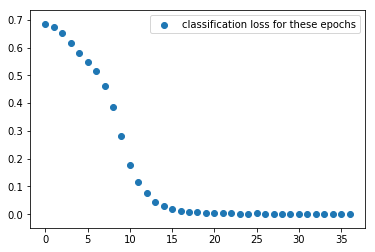

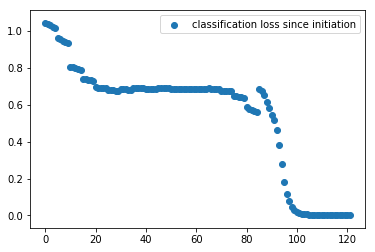

classification loss on last batch was: 0.0004617909239663479


In [7]:
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.0005)

### 3. Extraction

#### 3.1. Initial Examples

In Section 7.3 of the paper we note that the process sometimes needs one positive and one negative initial sample to get started. We take these from the training set, using the shortest sample from each class.

If extracting from a network you no longer have the train set for, you can also make such a list manually. 
Of course, there is nothing to stop you from having more than one initial sample from each class, or not using any, and so on.

In [8]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnn.classify_word(w)==True),None)
neg = next((w for w in all_words if rnn.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]
print(starting_examples)

['', '10']


#### 3.2. Clear the Computation Graph
If you're using our network classes, and just running one network at a time, you don't need this. Still, it's good practice. `renew` function resets the DyNet computation graph and refreshes the calling network's initial vectors.

In [9]:
rnn.renew()

#### 3.3. Extract
It is generally necessary to give the extraction some `starting_examples` to work with, so it doesn't get stuck on a single state automaton (Section 7.3. in the paper). We made those in Section 3.1. of this notebook.

You can set a `time_limit` on the extraction (default $50$ seconds) and the `initial_split_depth` (default $10$) for the initial aggressive refinement (which is described in Section 7.3.1. of our extraction paper).


During extraction, the method will report the counterexamples it finds, how long it took to find each one, and how long it took to refine the observation table (i.e. how long it took to update the $L^*$ automaton) between each two equivalence queries. Every time it starts a new equivalence query, if the proposed DFA has less than $30$ states, it will also display it.

provided counterexamples are: ['', '10']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 1


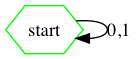

storing provided counterexample of length 2
returning counterexample of length 2:		10, this counterexample is rejected by the given RNN.
equivalence checking took: 0.014844000000003632
obs table refinement took 0.002
guided starting equivalence query for DFA of size 4


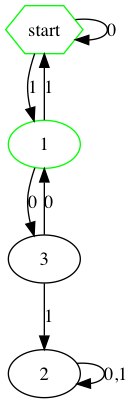

split wasn't perfect: gotta start over
returning counterexample of length 5:		10010, this counterexample is rejected by the given RNN.
equivalence checking took: 0.0820760000000007
obs table refinement took 0.003
guided starting equivalence query for DFA of size 5


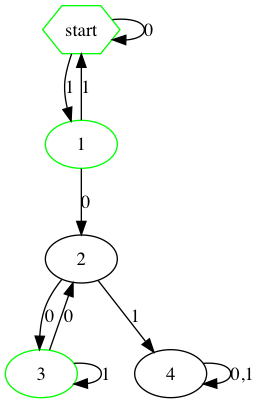

lstar successful: unrolling seems equivalent to proposed automaton
equivalence checking took: 0.023385999999995022
overall guided extraction time took: 0.1330209999999994
generated counterexamples were: (format: (counterexample, counterexample generation time))
('10', 0.014844000000003632)
('10010', 0.0820760000000007)


In [10]:
dfa = extract(rnn,time_limit = 50,initial_split_depth = 10,starting_examples=starting_examples)

#### 3.4. Get stats
Display the extracted DFA by using the `draw_nicely` function, which has optional parameters `maximum` (default $60$) and `force` (default `False`), and will only draw the DFA if it has less than `maximum` states or `force` is set to `True`.

Print some statistics you might find interesting about the network, such as the trained RNN's accuracy against its target, the extracted DFA's accuracy against the RNN, and the extracted DFA's accuracy against the original RNN's target.

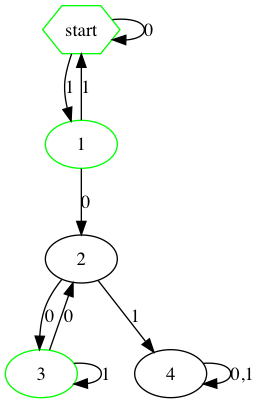

testing on train set, i.e. test set is train set
test set size: 2717
of which positive: 1306 (48.06%)
rnn score against target on test set: 2717 (100.0%)
extracted dfa score against rnn on test set: 2717 (100.0%)
extracted dfa score against target on rnn's test set: 2717 (100.0%)


In [11]:
from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfa.draw_nicely(maximum=30) #max size willing to draw

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")